In [1]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras import backend as K
from tensorflow.keras import utils
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn.model_selection import KFold
from os.path import isfile
from datetime import datetime
%matplotlib inline

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import Session

config = ConfigProto()
config.gpu_options.allow_growth = True
sess = Session(config=config)

if tf.test.gpu_device_name():
    print("GPU found")
else:
    print("No GPU found")

GPU found


## Load training and Validation arrays

In [3]:
dict_genres = {'Electronic':0, 'Experimental':1, 'Folk':2, 'Hip-Hop':3, 'Instrumental':4,'International':5, 'Pop' :6, 'Rock': 7}

reverse_map = {v: k for k, v in dict_genres.items()}
print(reverse_map)

{0: 'Electronic', 1: 'Experimental', 2: 'Folk', 3: 'Hip-Hop', 4: 'Instrumental', 5: 'International', 6: 'Pop', 7: 'Rock'}


In [4]:
npzfile = np.load('data/shuffled_train.npz')
print(npzfile.files)

X_train = npzfile['arr_0']
y_train = npzfile['arr_1']
print(X_train.shape, y_train.shape)

['arr_0', 'arr_1']
(6394, 640, 128) (6394,)


In [5]:
y_train = utils.to_categorical(y_train, num_classes=8).astype(int)
print(X_train.shape, y_train.shape)

(6394, 640, 128) (6394, 8)


In [6]:
npzfile = np.load('data/shuffled_valid.npz')
print(npzfile.files)

X_valid = npzfile['arr_0']
y_valid = npzfile['arr_1']
print(X_valid.shape, y_valid.shape)

['arr_0', 'arr_1']
(800, 640, 128) (800,)


In [7]:
y_valid = utils.to_categorical(y_valid, num_classes=8).astype(int)
print(X_valid.shape, y_valid.shape)

(800, 640, 128) (800, 8)


## Check by plotting a Spectogram

Pop


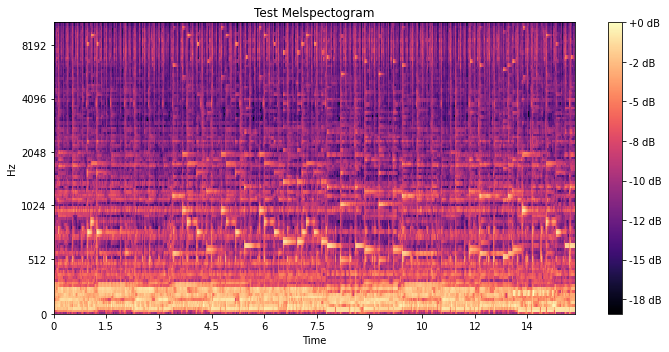

In [8]:
num = 0
spectogram = X_train[num]
genre = np.argmax(y_train[num])
print(reverse_map[genre])
plt.figure(figsize=(10, 5))
librosa.display.specshow(spectogram.T, y_axis='mel', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Test Melspectogram')
plt.tight_layout()

## Parallel CNN - RNN Model

In [9]:
batch_size = 32
num_classes = 2
n_features = X_train.shape[2]
n_time = X_train.shape[1]

In [10]:
nb_filters1=32
nb_filters2=64
nb_filters3=128
nb_filters4=512
ksize = (3,3)
pool_size_1= (2,2)

BATCH_SIZE = 64
EPOCH_COUNT = 30

def conv_recurrent_model_build(model_input):
    print('Building model...')
    layer = model_input
    
    ### Convolutional blocks
    conv_1 = Conv2D(filters = nb_filters1, kernel_size = ksize, strides=1, padding= 'valid', activation='relu', name='conv_1')(layer)
    pool_1 = MaxPooling2D(pool_size_1)(conv_1)

    conv_2 = Conv2D(filters = nb_filters2, kernel_size = ksize, strides=1, padding= 'valid', activation='relu', name='conv_2')(pool_1)
    pool_2 = MaxPooling2D(pool_size_1)(conv_2)

    conv_3 = Conv2D(filters = nb_filters3, kernel_size = ksize, strides=1, padding= 'valid', activation='relu', name='conv_3')(pool_2)
    pool_3 = MaxPooling2D(pool_size_1)(conv_3)
    
    conv_4 = Conv2D(filters = nb_filters4, kernel_size = ksize, strides=1, padding= 'valid', activation='relu', name='conv_4')(pool_3)
    pool_4 = MaxPooling2D(pool_size_1)(conv_4)
    
    flatten1 = Flatten()(pool_4)
    
    output = Dense(num_classes, activation = 'softmax', name='preds')(flatten1)
    
    model_output = output
    model = Model(model_input, model_output)
    
    opt = Adam(learning_rate=0.001)
    
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return model

In [11]:
def train_model(x_train, y_train, x_val, y_val, info = "", genres_name = ""):
    n_frames = 640
    n_frequency = 128
    
    #reshape and expand dims for conv2d
    x_train = np.expand_dims(x_train, axis = -1)
    x_val = np.expand_dims(x_val, axis = -1)
       
    input_shape = (n_frames, n_frequency, 1)
    model_input = Input(input_shape, name='input')
    
    model = conv_recurrent_model_build(model_input)
    
    log_dir = ".\\logs\\model_root\\"+datetime.now().strftime("%Y%m%d-%H%M%S_")+info
    tb_callback = TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True, write_images=False, update_freq='batch', profile_batch=2, embeddings_freq=0, embeddings_metadata=None)

    model_folder = "./models/model_root/{}".format(info)
    os.makedirs(model_folder, exist_ok=True)
    
    f = open("{}/info.txt".format(model_folder), "w")
    f.write("genre name split: {}".format(genres_name))
    checkpoint_callback = ModelCheckpoint('{}/model.h5'.format(model_folder), monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    
    reducelr_callback = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=10, min_delta=0.01, verbose=1)
    callbacks_list = [tb_callback, checkpoint_callback, reducelr_callback]
    
    f.close()
    
    # Fit the model and get training history.
    print('Training...')
    history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCH_COUNT, validation_data=(x_val, y_val), verbose=1, callbacks=callbacks_list)
    
    return model, history

In [12]:
def chunks(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

In [13]:
def create_split(elem, c):
    splits = []
    for i in range(c):
        equal = False
        np.random.shuffle(elem)
        new_split = list(chunks(elem, int(len(elem)/2)))
        for split in splits:
            if set(new_split[0]) == set(split[0]) and set(new_split[0]) == set(split[1]):
                equal = True
                break
            
        if equal:
            i-=1
            continue
        
        splits.append(new_split)
        
    return splits

In [14]:
def show_summary_stats(history):
    # List all data in history
    print(history.history.keys())

    # Summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

Folder num 1
Genre split [['Folk', 'Hip-Hop', 'Pop', 'Rock'], ['Experimental', 'International', 'Electronic', 'Instrumental']]
Building model...
Training...
Epoch 1/30
107/107 [==============================] - 30s 145ms/step - loss: 1.3001 - accuracy: 0.5370 - val_loss: 0.6465 - val_accuracy: 0.6528

Epoch 00001: val_accuracy improved from -inf to 0.65278, saving model to ./models/model/folder1\model.h5
Epoch 2/30
107/107 [==============================] - 15s 143ms/step - loss: 0.6722 - accuracy: 0.5837 - val_loss: 0.6118 - val_accuracy: 0.6861

Epoch 00002: val_accuracy improved from 0.65278 to 0.68611, saving model to ./models/model/folder1\model.h5
Epoch 3/30
107/107 [==============================] - 13s 119ms/step - loss: 0.6329 - accuracy: 0.6397 - val_loss: 0.6590 - val_accuracy: 0.5444

Epoch 00003: val_accuracy did not improve from 0.68611
Epoch 4/30
107/107 [==============================] - 13s 119ms/step - loss: 0.6376 - accuracy: 0.6359 - val_loss: 0.5691 - val_accuracy:

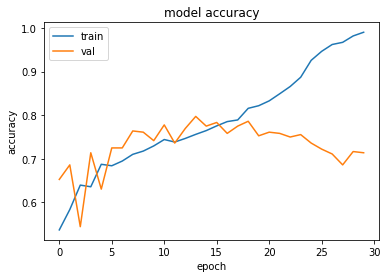

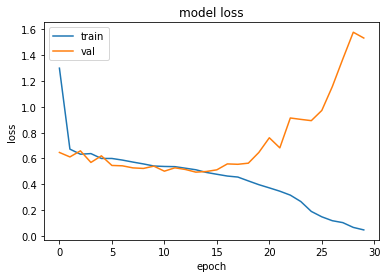

Folder num 2
Genre split [['International', 'Instrumental', 'Hip-Hop', 'Rock'], ['Experimental', 'Folk', 'Pop', 'Electronic']]
Building model...
Training...
Epoch 1/30
107/107 [==============================] - 21s 181ms/step - loss: 1.0763 - accuracy: 0.4988 - val_loss: 0.6927 - val_accuracy: 0.5389

Epoch 00001: val_accuracy improved from -inf to 0.53889, saving model to ./models/model/folder2\model.h5
Epoch 2/30
107/107 [==============================] - 13s 119ms/step - loss: 0.7001 - accuracy: 0.5047 - val_loss: 0.6915 - val_accuracy: 0.5306

Epoch 00002: val_accuracy did not improve from 0.53889
Epoch 3/30
107/107 [==============================] - 13s 120ms/step - loss: 0.6933 - accuracy: 0.4883 - val_loss: 0.6930 - val_accuracy: 0.5472

Epoch 00003: val_accuracy improved from 0.53889 to 0.54722, saving model to ./models/model/folder2\model.h5
Epoch 4/30
107/107 [==============================] - 13s 120ms/step - loss: 0.6966 - accuracy: 0.5040 - val_loss: 0.6950 - val_accuracy:

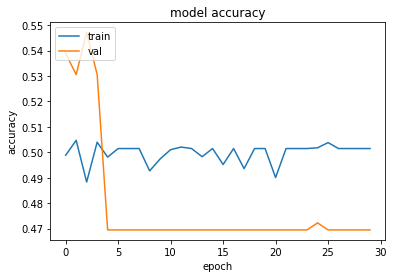

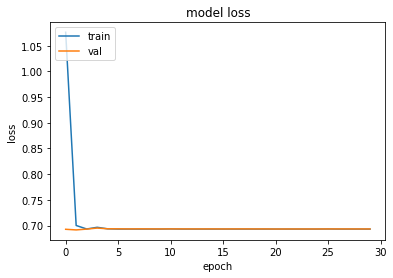

Folder num 3
Genre split [['Hip-Hop', 'Pop', 'Electronic', 'Folk'], ['Rock', 'International', 'Instrumental', 'Experimental']]
Building model...
Training...
Epoch 1/30
107/107 [==============================] - 15s 124ms/step - loss: 1.2455 - accuracy: 0.5060 - val_loss: 0.6912 - val_accuracy: 0.4972

Epoch 00001: val_accuracy improved from -inf to 0.49722, saving model to ./models/model/folder3\model.h5
Epoch 2/30
107/107 [==============================] - 13s 119ms/step - loss: 0.6946 - accuracy: 0.5310 - val_loss: 0.7081 - val_accuracy: 0.4972

Epoch 00002: val_accuracy did not improve from 0.49722
Epoch 3/30
107/107 [==============================] - 13s 119ms/step - loss: 0.6892 - accuracy: 0.5413 - val_loss: 0.6780 - val_accuracy: 0.5639

Epoch 00003: val_accuracy improved from 0.49722 to 0.56389, saving model to ./models/model/folder3\model.h5
Epoch 4/30
107/107 [==============================] - 13s 120ms/step - loss: 0.6838 - accuracy: 0.5626 - val_loss: 0.6555 - val_accuracy:

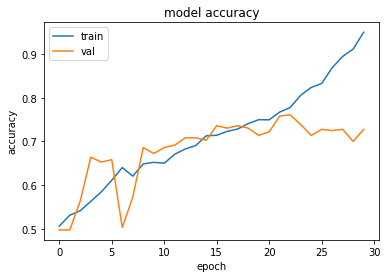

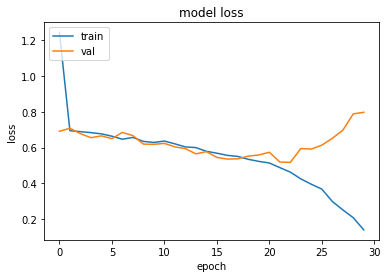

Folder num 4
Genre split [['Hip-Hop', 'Instrumental', 'Pop', 'Folk'], ['Experimental', 'Rock', 'Electronic', 'International']]
Building model...
Training...
Epoch 1/30
107/107 [==============================] - 18s 154ms/step - loss: 1.2182 - accuracy: 0.5124 - val_loss: 0.6922 - val_accuracy: 0.5278

Epoch 00001: val_accuracy improved from -inf to 0.52778, saving model to ./models/model/folder4\model.h5
Epoch 2/30
107/107 [==============================] - 13s 121ms/step - loss: 0.6940 - accuracy: 0.5057 - val_loss: 0.6929 - val_accuracy: 0.5278

Epoch 00002: val_accuracy did not improve from 0.52778
Epoch 3/30
107/107 [==============================] - 13s 122ms/step - loss: 0.6939 - accuracy: 0.5019 - val_loss: 0.6991 - val_accuracy: 0.4722

Epoch 00003: val_accuracy did not improve from 0.52778
Epoch 4/30
107/107 [==============================] - 13s 124ms/step - loss: 0.6942 - accuracy: 0.4877 - val_loss: 0.6938 - val_accuracy: 0.4722

Epoch 00004: val_accuracy did not improve fr

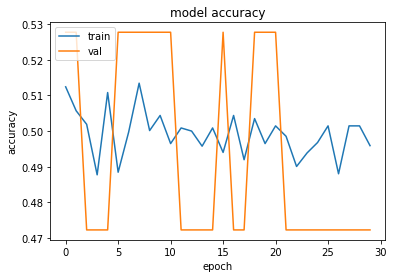

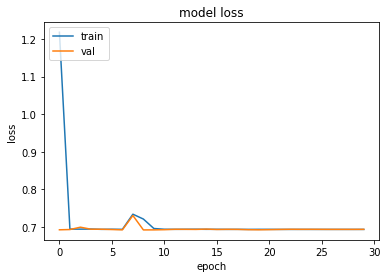

Folder num 5
Genre split [['Hip-Hop', 'Pop', 'International', 'Rock'], ['Folk', 'Electronic', 'Instrumental', 'Experimental']]
Building model...
Training...
Epoch 1/30
107/107 [==============================] - 14s 124ms/step - loss: 1.1968 - accuracy: 0.5356 - val_loss: 0.6903 - val_accuracy: 0.4806

Epoch 00001: val_accuracy improved from -inf to 0.48056, saving model to ./models/model/folder5\model.h5
Epoch 2/30
107/107 [==============================] - 13s 119ms/step - loss: 0.6824 - accuracy: 0.5609 - val_loss: 0.6800 - val_accuracy: 0.4750

Epoch 00002: val_accuracy did not improve from 0.48056
Epoch 3/30
107/107 [==============================] - 13s 119ms/step - loss: 0.6460 - accuracy: 0.6134 - val_loss: 0.6489 - val_accuracy: 0.6472

Epoch 00003: val_accuracy improved from 0.48056 to 0.64722, saving model to ./models/model/folder5\model.h5
Epoch 4/30
107/107 [==============================] - 13s 119ms/step - loss: 0.6034 - accuracy: 0.6806 - val_loss: 0.5573 - val_accuracy:

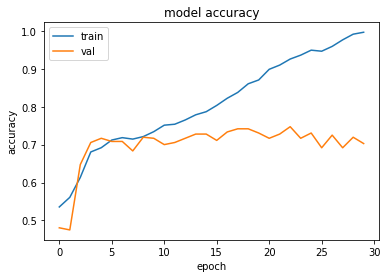

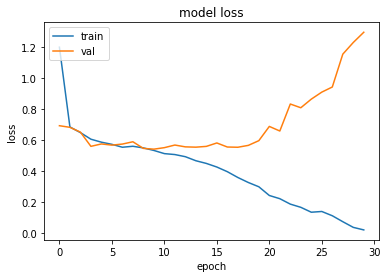

Folder num 6
Genre split [['Experimental', 'Pop', 'Instrumental', 'Rock'], ['International', 'Electronic', 'Folk', 'Hip-Hop']]
Building model...
Training...
Epoch 1/30
107/107 [==============================] - 16s 126ms/step - loss: 0.9141 - accuracy: 0.5309 - val_loss: 0.6928 - val_accuracy: 0.4944

Epoch 00001: val_accuracy improved from -inf to 0.49444, saving model to ./models/model/folder6\model.h5
Epoch 2/30
107/107 [==============================] - 13s 121ms/step - loss: 0.6821 - accuracy: 0.5587 - val_loss: 0.7088 - val_accuracy: 0.5167

Epoch 00002: val_accuracy improved from 0.49444 to 0.51667, saving model to ./models/model/folder6\model.h5
Epoch 3/30
107/107 [==============================] - 13s 120ms/step - loss: 0.6243 - accuracy: 0.6551 - val_loss: 0.6489 - val_accuracy: 0.6194

Epoch 00003: val_accuracy improved from 0.51667 to 0.61944, saving model to ./models/model/folder6\model.h5
Epoch 4/30
107/107 [==============================] - 13s 126ms/step - loss: 0.5812 

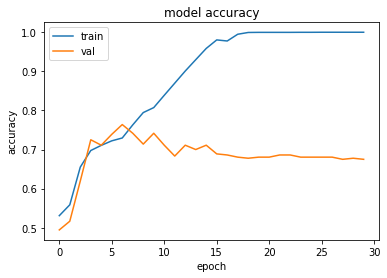

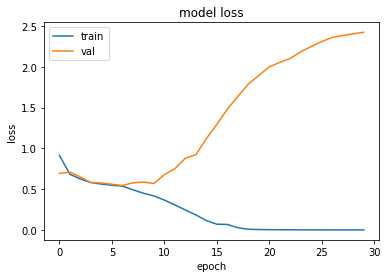

Folder num 7
Genre split [['International', 'Electronic', 'Instrumental', 'Pop'], ['Hip-Hop', 'Folk', 'Experimental', 'Rock']]
Building model...
Training...
Epoch 1/30
107/107 [==============================] - 15s 124ms/step - loss: 1.0960 - accuracy: 0.5203 - val_loss: 0.7113 - val_accuracy: 0.4778

Epoch 00001: val_accuracy improved from -inf to 0.47778, saving model to ./models/model/folder7\model.h5
Epoch 2/30
107/107 [==============================] - 13s 119ms/step - loss: 0.6941 - accuracy: 0.5100 - val_loss: 0.6918 - val_accuracy: 0.5500

Epoch 00002: val_accuracy improved from 0.47778 to 0.55000, saving model to ./models/model/folder7\model.h5
Epoch 3/30
107/107 [==============================] - 13s 119ms/step - loss: 0.7110 - accuracy: 0.5092 - val_loss: 0.6918 - val_accuracy: 0.5361

Epoch 00003: val_accuracy did not improve from 0.55000
Epoch 4/30
107/107 [==============================] - 13s 122ms/step - loss: 0.6960 - accuracy: 0.5151 - val_loss: 0.6975 - val_accuracy:

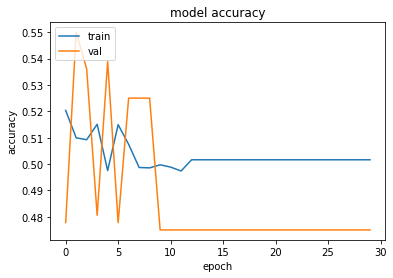

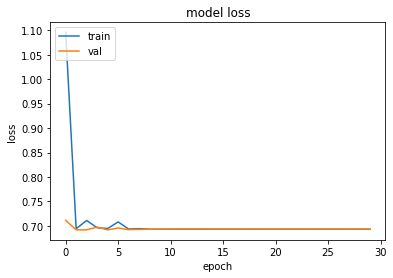

Folder num 8
Genre split [['Electronic', 'Folk', 'Hip-Hop', 'Instrumental'], ['Experimental', 'International', 'Pop', 'Rock']]
Building model...
Training...
Epoch 1/30
107/107 [==============================] - 14s 123ms/step - loss: 1.0051 - accuracy: 0.5253 - val_loss: 0.6821 - val_accuracy: 0.6139

Epoch 00001: val_accuracy improved from -inf to 0.61389, saving model to ./models/model/folder8\model.h5
Epoch 2/30
107/107 [==============================] - 13s 123ms/step - loss: 0.6639 - accuracy: 0.6093 - val_loss: 0.6292 - val_accuracy: 0.6528

Epoch 00002: val_accuracy improved from 0.61389 to 0.65278, saving model to ./models/model/folder8\model.h5
Epoch 3/30
107/107 [==============================] - 13s 120ms/step - loss: 0.6269 - accuracy: 0.6466 - val_loss: 0.5764 - val_accuracy: 0.6917

Epoch 00003: val_accuracy improved from 0.65278 to 0.69167, saving model to ./models/model/folder8\model.h5
Epoch 4/30
107/107 [==============================] - 13s 119ms/step - loss: 0.6034 

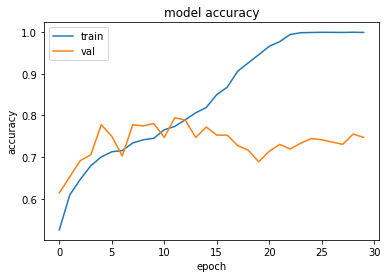

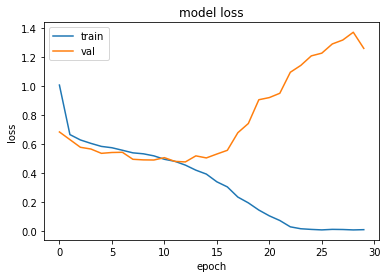

Folder num 9
Genre split [['Experimental', 'International', 'Hip-Hop', 'Instrumental'], ['Rock', 'Folk', 'Electronic', 'Pop']]
Building model...
Training...
Epoch 1/30
107/107 [==============================] - 17s 122ms/step - loss: 1.1947 - accuracy: 0.5171 - val_loss: 0.6973 - val_accuracy: 0.4722

Epoch 00001: val_accuracy improved from -inf to 0.47222, saving model to ./models/model/folder9\model.h5
Epoch 2/30
107/107 [==============================] - 13s 121ms/step - loss: 0.6889 - accuracy: 0.5394 - val_loss: 0.6633 - val_accuracy: 0.6167

Epoch 00002: val_accuracy improved from 0.47222 to 0.61667, saving model to ./models/model/folder9\model.h5
Epoch 3/30
107/107 [==============================] - 13s 120ms/step - loss: 0.6648 - accuracy: 0.6105 - val_loss: 0.6970 - val_accuracy: 0.5278

Epoch 00003: val_accuracy did not improve from 0.61667
Epoch 4/30
107/107 [==============================] - 13s 119ms/step - loss: 0.6758 - accuracy: 0.5817 - val_loss: 0.6567 - val_accuracy:

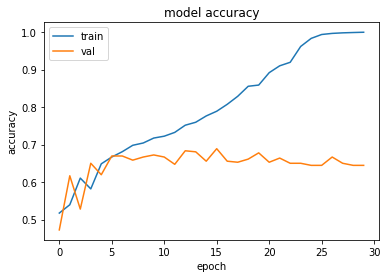

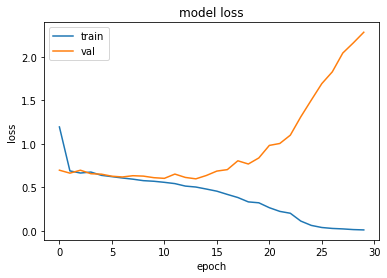

Folder num 10
Genre split [['Experimental', 'Folk', 'Rock', 'International'], ['Electronic', 'Hip-Hop', 'Instrumental', 'Pop']]
Building model...
Training...
Epoch 1/30
107/107 [==============================] - 16s 125ms/step - loss: 0.9862 - accuracy: 0.4962 - val_loss: 0.6935 - val_accuracy: 0.4833

Epoch 00001: val_accuracy improved from -inf to 0.48333, saving model to ./models/model/folder10\model.h5
Epoch 2/30
107/107 [==============================] - 13s 123ms/step - loss: 0.6932 - accuracy: 0.4963 - val_loss: 0.6932 - val_accuracy: 0.4833

Epoch 00002: val_accuracy did not improve from 0.48333
Epoch 3/30
107/107 [==============================] - 13s 122ms/step - loss: 0.6932 - accuracy: 0.4939 - val_loss: 0.6932 - val_accuracy: 0.4833

Epoch 00003: val_accuracy did not improve from 0.48333
Epoch 4/30
107/107 [==============================] - 13s 121ms/step - loss: 0.6932 - accuracy: 0.4950 - val_loss: 0.6935 - val_accuracy: 0.4833

Epoch 00004: val_accuracy did not improve 

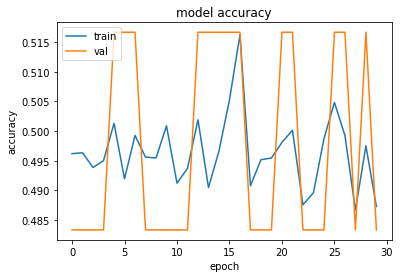

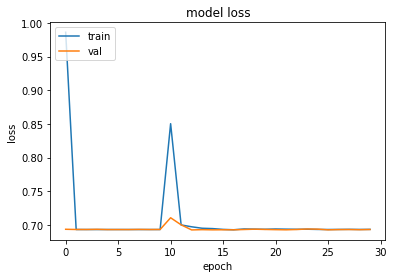

Folder num 11
Genre split [['Instrumental', 'Rock', 'Folk', 'Hip-Hop'], ['Pop', 'Experimental', 'Electronic', 'International']]
Building model...
Training...
Epoch 1/30
107/107 [==============================] - 15s 123ms/step - loss: 1.1995 - accuracy: 0.5102 - val_loss: 0.6737 - val_accuracy: 0.5944

Epoch 00001: val_accuracy improved from -inf to 0.59444, saving model to ./models/model/folder11\model.h5
Epoch 2/30
107/107 [==============================] - 13s 119ms/step - loss: 0.6731 - accuracy: 0.5831 - val_loss: 0.6903 - val_accuracy: 0.6083

Epoch 00002: val_accuracy improved from 0.59444 to 0.60833, saving model to ./models/model/folder11\model.h5
Epoch 3/30
107/107 [==============================] - 13s 119ms/step - loss: 0.6587 - accuracy: 0.6105 - val_loss: 0.6510 - val_accuracy: 0.6278

Epoch 00003: val_accuracy improved from 0.60833 to 0.62778, saving model to ./models/model/folder11\model.h5
Epoch 4/30
107/107 [==============================] - 13s 119ms/step - loss: 0.6

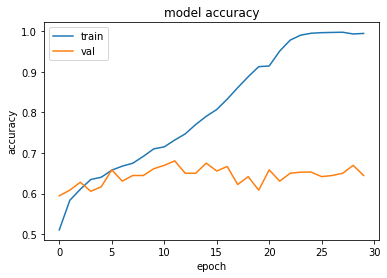

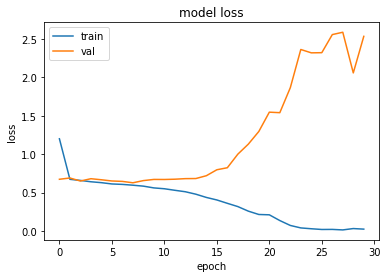

Folder num 12
Genre split [['Hip-Hop', 'International', 'Electronic', 'Instrumental'], ['Folk', 'Experimental', 'Pop', 'Rock']]
Building model...
Training...
Epoch 1/30
107/107 [==============================] - 16s 124ms/step - loss: 1.1065 - accuracy: 0.5566 - val_loss: 0.7135 - val_accuracy: 0.5139

Epoch 00001: val_accuracy improved from -inf to 0.51389, saving model to ./models/model/folder12\model.h5
Epoch 2/30
107/107 [==============================] - 16s 147ms/step - loss: 0.6477 - accuracy: 0.6301 - val_loss: 0.5876 - val_accuracy: 0.7000

Epoch 00002: val_accuracy improved from 0.51389 to 0.70000, saving model to ./models/model/folder12\model.h5
Epoch 3/30
107/107 [==============================] - 13s 120ms/step - loss: 0.6069 - accuracy: 0.6835 - val_loss: 0.5564 - val_accuracy: 0.7472

Epoch 00003: val_accuracy improved from 0.70000 to 0.74722, saving model to ./models/model/folder12\model.h5
Epoch 4/30
107/107 [==============================] - 13s 119ms/step - loss: 0.5

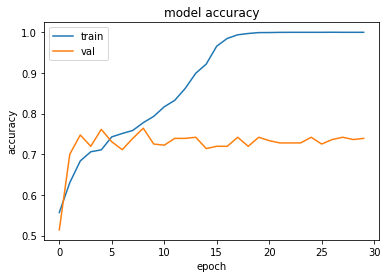

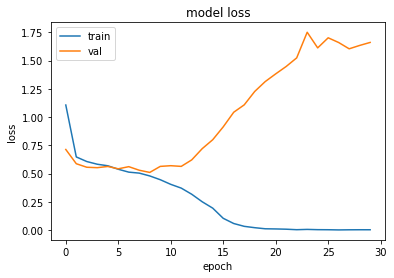

Folder num 13
Genre split [['Instrumental', 'Folk', 'Experimental', 'International'], ['Electronic', 'Hip-Hop', 'Rock', 'Pop']]
Building model...
Training...
Epoch 1/30
107/107 [==============================] - 15s 125ms/step - loss: 1.0303 - accuracy: 0.5347 - val_loss: 0.6899 - val_accuracy: 0.5361

Epoch 00001: val_accuracy improved from -inf to 0.53611, saving model to ./models/model/folder13\model.h5
Epoch 2/30
107/107 [==============================] - 13s 120ms/step - loss: 0.6592 - accuracy: 0.6062 - val_loss: 0.5834 - val_accuracy: 0.6667

Epoch 00002: val_accuracy improved from 0.53611 to 0.66667, saving model to ./models/model/folder13\model.h5
Epoch 3/30
107/107 [==============================] - 13s 119ms/step - loss: 0.6125 - accuracy: 0.6823 - val_loss: 0.5885 - val_accuracy: 0.7278

Epoch 00003: val_accuracy improved from 0.66667 to 0.72778, saving model to ./models/model/folder13\model.h5
Epoch 4/30
107/107 [==============================] - 13s 120ms/step - loss: 0.5

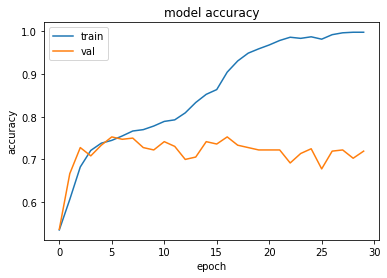

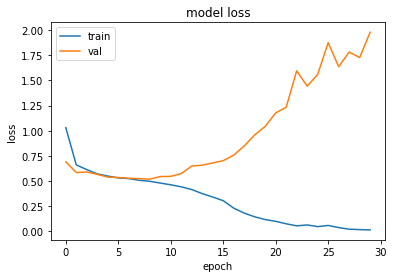

Folder num 14
Genre split [['Pop', 'Experimental', 'Folk', 'Instrumental'], ['International', 'Rock', 'Hip-Hop', 'Electronic']]
Building model...
Training...
Epoch 1/30
107/107 [==============================] - 15s 125ms/step - loss: 1.0049 - accuracy: 0.5484 - val_loss: 0.7747 - val_accuracy: 0.5139

Epoch 00001: val_accuracy improved from -inf to 0.51389, saving model to ./models/model/folder14\model.h5
Epoch 2/30
107/107 [==============================] - 13s 120ms/step - loss: 0.6239 - accuracy: 0.6551 - val_loss: 0.6541 - val_accuracy: 0.5917

Epoch 00002: val_accuracy improved from 0.51389 to 0.59167, saving model to ./models/model/folder14\model.h5
Epoch 3/30
107/107 [==============================] - 13s 120ms/step - loss: 0.5950 - accuracy: 0.6790 - val_loss: 0.6580 - val_accuracy: 0.6500

Epoch 00003: val_accuracy improved from 0.59167 to 0.65000, saving model to ./models/model/folder14\model.h5
Epoch 4/30
107/107 [==============================] - 13s 120ms/step - loss: 0.5

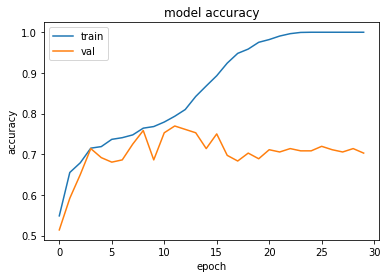

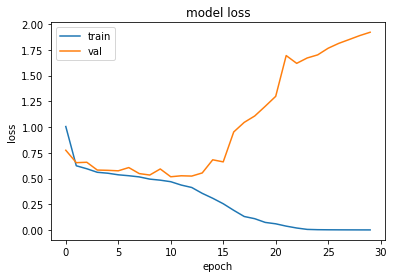

Folder num 15
Genre split [['Instrumental', 'Pop', 'Experimental', 'Electronic'], ['Folk', 'Rock', 'International', 'Hip-Hop']]
Building model...
Training...
Epoch 1/30
107/107 [==============================] - 17s 145ms/step - loss: 1.0904 - accuracy: 0.5078 - val_loss: 0.6913 - val_accuracy: 0.5265

Epoch 00001: val_accuracy improved from -inf to 0.52646, saving model to ./models/model/folder15\model.h5
Epoch 2/30
107/107 [==============================] - 13s 120ms/step - loss: 0.6936 - accuracy: 0.5004 - val_loss: 0.6934 - val_accuracy: 0.4735

Epoch 00002: val_accuracy did not improve from 0.52646
Epoch 3/30
107/107 [==============================] - 13s 120ms/step - loss: 0.6938 - accuracy: 0.4945 - val_loss: 0.6939 - val_accuracy: 0.4735

Epoch 00003: val_accuracy did not improve from 0.52646
Epoch 4/30
107/107 [==============================] - 13s 121ms/step - loss: 0.6933 - accuracy: 0.4990 - val_loss: 0.6928 - val_accuracy: 0.5265

Epoch 00004: val_accuracy did not improve 

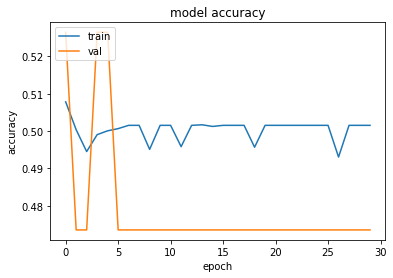

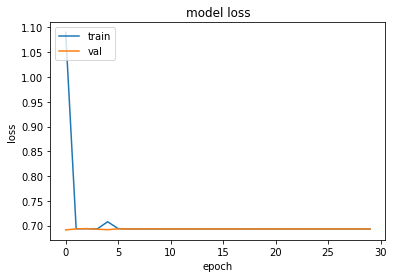

Folder num 16
Genre split [['Hip-Hop', 'Instrumental', 'Electronic', 'International'], ['Pop', 'Experimental', 'Rock', 'Folk']]
Building model...
Training...
Epoch 1/30
107/107 [==============================] - 15s 125ms/step - loss: 1.0588 - accuracy: 0.5260 - val_loss: 0.6819 - val_accuracy: 0.5181

Epoch 00001: val_accuracy improved from -inf to 0.51811, saving model to ./models/model/folder16\model.h5
Epoch 2/30
107/107 [==============================] - 13s 119ms/step - loss: 0.6581 - accuracy: 0.6136 - val_loss: 0.6065 - val_accuracy: 0.6964

Epoch 00002: val_accuracy improved from 0.51811 to 0.69638, saving model to ./models/model/folder16\model.h5
Epoch 3/30
107/107 [==============================] - 13s 122ms/step - loss: 0.6121 - accuracy: 0.6775 - val_loss: 0.6083 - val_accuracy: 0.6852

Epoch 00003: val_accuracy did not improve from 0.69638
Epoch 4/30
107/107 [==============================] - 13s 120ms/step - loss: 0.5798 - accuracy: 0.7040 - val_loss: 0.5825 - val_accura

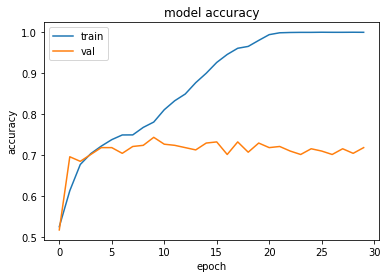

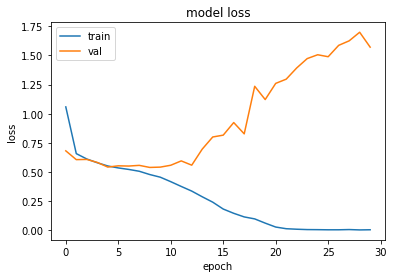

Folder num 17
Genre split [['Rock', 'Pop', 'Folk', 'Hip-Hop'], ['Instrumental', 'Experimental', 'Electronic', 'International']]
Building model...
Training...
Epoch 1/30
107/107 [==============================] - 17s 126ms/step - loss: 1.0586 - accuracy: 0.5090 - val_loss: 0.6916 - val_accuracy: 0.5042

Epoch 00001: val_accuracy improved from -inf to 0.50418, saving model to ./models/model/folder17\model.h5
Epoch 2/30
107/107 [==============================] - 13s 119ms/step - loss: 0.6944 - accuracy: 0.5020 - val_loss: 0.6918 - val_accuracy: 0.5042

Epoch 00002: val_accuracy did not improve from 0.50418
Epoch 3/30
107/107 [==============================] - 13s 119ms/step - loss: 0.6929 - accuracy: 0.5170 - val_loss: 0.7877 - val_accuracy: 0.4958

Epoch 00003: val_accuracy did not improve from 0.50418
Epoch 4/30
107/107 [==============================] - 13s 125ms/step - loss: 0.6892 - accuracy: 0.5197 - val_loss: 0.6922 - val_accuracy: 0.5153

Epoch 00004: val_accuracy improved from 0.

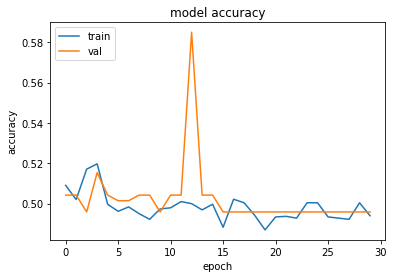

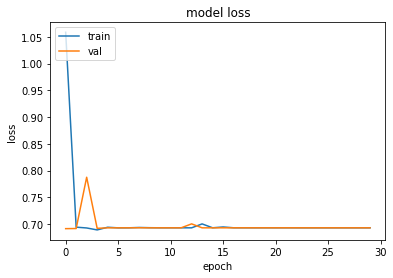

Folder num 18
Genre split [['International', 'Electronic', 'Experimental', 'Hip-Hop'], ['Instrumental', 'Pop', 'Rock', 'Folk']]
Building model...
Training...
Epoch 1/30
107/107 [==============================] - 15s 124ms/step - loss: 1.0892 - accuracy: 0.5611 - val_loss: 0.6155 - val_accuracy: 0.7159

Epoch 00001: val_accuracy improved from -inf to 0.71588, saving model to ./models/model/folder18\model.h5
Epoch 2/30
107/107 [==============================] - 13s 120ms/step - loss: 0.5917 - accuracy: 0.6942 - val_loss: 0.5391 - val_accuracy: 0.7493

Epoch 00002: val_accuracy improved from 0.71588 to 0.74930, saving model to ./models/model/folder18\model.h5
Epoch 3/30
107/107 [==============================] - 13s 120ms/step - loss: 0.5388 - accuracy: 0.7448 - val_loss: 0.5133 - val_accuracy: 0.7604

Epoch 00003: val_accuracy improved from 0.74930 to 0.76045, saving model to ./models/model/folder18\model.h5
Epoch 4/30
107/107 [==============================] - 13s 120ms/step - loss: 0.5

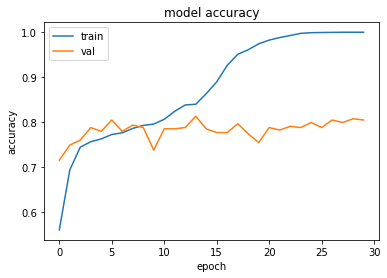

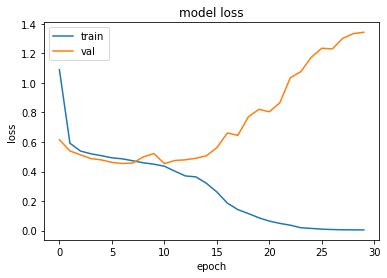

Folder num 19
Genre split [['Electronic', 'Folk', 'Instrumental', 'Hip-Hop'], ['Experimental', 'International', 'Rock', 'Pop']]
Building model...
Training...
Epoch 1/30
107/107 [==============================] - 15s 124ms/step - loss: 1.1015 - accuracy: 0.5406 - val_loss: 0.6515 - val_accuracy: 0.6240

Epoch 00001: val_accuracy improved from -inf to 0.62396, saving model to ./models/model/folder19\model.h5
Epoch 2/30
107/107 [==============================] - 13s 121ms/step - loss: 0.6922 - accuracy: 0.5582 - val_loss: 0.6374 - val_accuracy: 0.6407

Epoch 00002: val_accuracy improved from 0.62396 to 0.64067, saving model to ./models/model/folder19\model.h5
Epoch 3/30
107/107 [==============================] - 13s 120ms/step - loss: 0.6665 - accuracy: 0.5895 - val_loss: 0.6095 - val_accuracy: 0.6407

Epoch 00003: val_accuracy did not improve from 0.64067
Epoch 4/30
107/107 [==============================] - 13s 120ms/step - loss: 0.6478 - accuracy: 0.6231 - val_loss: 0.6362 - val_accura

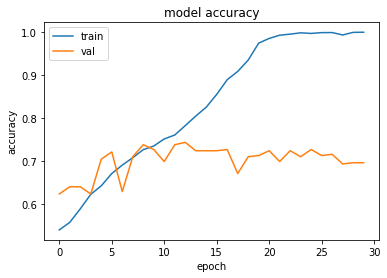

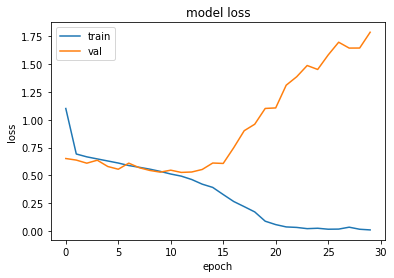

Folder num 20
Genre split [['Electronic', 'Pop', 'Folk', 'Rock'], ['Instrumental', 'Experimental', 'Hip-Hop', 'International']]
Building model...
Training...
Epoch 1/30
107/107 [==============================] - 15s 126ms/step - loss: 0.8072 - accuracy: 0.5327 - val_loss: 0.7007 - val_accuracy: 0.5348

Epoch 00001: val_accuracy improved from -inf to 0.53482, saving model to ./models/model/folder20\model.h5
Epoch 2/30
107/107 [==============================] - 13s 121ms/step - loss: 0.6663 - accuracy: 0.6018 - val_loss: 0.6567 - val_accuracy: 0.6379

Epoch 00002: val_accuracy improved from 0.53482 to 0.63788, saving model to ./models/model/folder20\model.h5
Epoch 3/30
107/107 [==============================] - 13s 121ms/step - loss: 0.6392 - accuracy: 0.6385 - val_loss: 0.6050 - val_accuracy: 0.6852

Epoch 00003: val_accuracy improved from 0.63788 to 0.68524, saving model to ./models/model/folder20\model.h5
Epoch 4/30
107/107 [==============================] - 13s 121ms/step - loss: 0.6

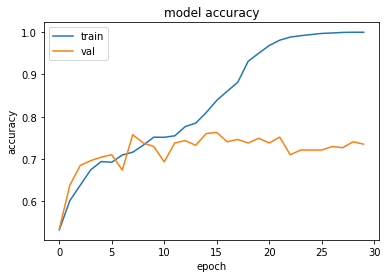

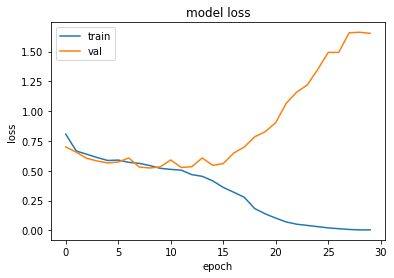

In [15]:
X_train_cross = np.concatenate((X_train, X_valid), axis=0)
y_train_cross = np.concatenate((y_train, y_valid), axis=0)

num_splits = 8

kfold = KFold(n_splits=8, shuffle=True)
genre_splits = create_split(list(dict_genres.values()), num_splits)

fold_no = 1
for train, test in kfold.split(X_train_cross, y_train_cross):
    #split = genre_splits[fold_no - 1]
    dict_genres_list = list(dict_genres.values())
    split = [[dict_genres_list[fold_no - 1]], dict_genres_list.pop(fold_no - 1)]
    
    y_train_cross_binary = np.argmax(y_train_cross, axis=1)
    y_train_cross_binary = np.in1d(y_train_cross_binary, split[0])
    y_train_cross_binary = utils.to_categorical(y_train_cross_binary*1, num_classes=2)
    
    print("Folder num {}".format(fold_no))
    genres_name = [[reverse_map[g] for g in split_l] for split_l in split]
    print("Genre split {}".format(genres_name))
    
    model, history  = train_model(X_train_cross[train], y_train_cross_binary[train], X_train_cross[test], y_train_cross_binary[test], "folder{}".format(fold_no), genres_name)
    show_summary_stats(history)
    
    fold_no += 1
    if fold_no > num_splits:
        break